In [2]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [3]:
import mdtraj as md
import seaborn as sns

## Make HMM from MSM

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

In [5]:
from scipy.stats import skew, kurtosis

In [6]:
M = pickle.load(open('Data/Chodera_data/Processed/MSM_lag1.0.pickle', 'rb'))
HMM = pickle.load(open('Data/Chodera_data/Processed/HMM_lag1.0.pickle', 'rb'))

In [7]:
stat_dist = HMM.stationary_distribution_obs

In [8]:
membership = HMM.metastable_memberships
print(membership.shape)
n_sets = HMM.nstates

(500, 4)


In [9]:
free_energy = -np.log(stat_dist)

In [10]:
free_energy_by_state = [free_energy*membership[:,i] for i in range(n_sets)]

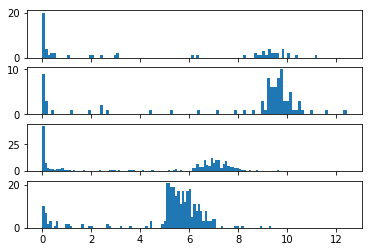

In [11]:
fig, axes = plt.subplots(n_sets, sharex=True)
tol = 1e-7
for i, ax in enumerate(axes):
    ax.hist(free_energy_by_state[i][np.where(free_energy_by_state[i]>tol)[0]], bins=100)

In [12]:
properties = {}
properties['mean'] = [np.mean(x) for x in free_energy_by_state]
properties['max'] = [np.max(x) for x in free_energy_by_state]
properties['std'] = [np.std(x) for x in free_energy_by_state]
properties['skew'] = [skew(x) for x in free_energy_by_state]
properties['kurtosis'] = [kurtosis(x) for x in free_energy_by_state]

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [14]:
scaled_properties = {}
for k, v in properties.items():
    scaled_properties[k] = [x[0] for x in scaler.fit_transform(np.array(v).reshape(-1,1))]

In [15]:
scaled_properties

{'kurtosis': [1.0, 0.3172362704703503, 0.071884341018823822, 0.0],
 'max': [0.61377045694355115, 1.0000000000000004, 0.11115892893968748, 0.0],
 'mean': [0.0, 0.28823013604086822, 0.52893395478694327, 1.0],
 'skew': [1.0, 0.58184841815041322, 0.29821110670879791, 0.0],
 'std': [0.0, 1.0, 0.83762593906407989, 0.63476360979821544]}

In [17]:
pickle.dump( scaled_properties, open('Data/Chodera_data/Processed/static_properties_01_scale.pickle', 'wb'))

In [18]:
scaled_properties = {}
for k, v in properties.items():
    v = np.abs(v)
    scaled_properties[k] = list(np.array(v)/np.max(v))

In [19]:
pickle.dump(scaled_properties, open('Data/Chodera_data/Processed/static_properties_max_scale.pickle', 'wb'))

In [20]:
scaled_properties

{'kurtosis': [1.0,
  0.21732346763586047,
  0.063932242131060593,
  0.14633583846540726],
 'max': [0.90425199668711653, 1.0, 0.77965238717103702, 0.75209559953602645],
 'mean': [0.17946446144978281, 0.41596753135247899, 0.61347356889838356, 1.0],
 'skew': [1.0, 0.57089683875937092, 0.2798309376164449, 0.026190453095025348],
 'std': [0.66079179198585891, 1.0, 0.94492138576194751, 0.87610881857809908]}